# Description of the breast lesion deep learning project

## Motivation and notes

## Publications data sources

Al-Dhabyani, W., Gomaa, M., Khaled, H., & Fahmy, A. (2019). Dataset of breast ultrasound images. Data in brief, 28, 104863. https://doi.org/10.1016/j.dib.2019.104863

Pawłowska, A., Ćwierz-Pieńkowska, A., Domalik, A., Jaguś, D., Kasprzak, P., Matkowski, R., Fura, Ł., Nowicki, A., & Zolek, N. (2024). A Curated Benchmark Dataset for Ultrasound Based Breast Lesion Analysis (Breast-Lesions-USG) (Version 1) [dataset]. The Cancer Imaging Archive. https://doi.org/10.7937/9WKK-Q141

**the following data is not included yet**

A. Abbasian Ardakani, A. Mohammadi, M. Mirza-Aghazadeh-Attari, U.R. Acharya, An open-access breast lesion ultrasound image database‏: Applicable in artificial intelligence studies, Computers in Biology and Medicine, 152 (2023) 106438. https://doi.org/10.1016/j.compbiomed.2022.106438



In [ ]:
# Imports
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Data exploration 

## Plotting example images

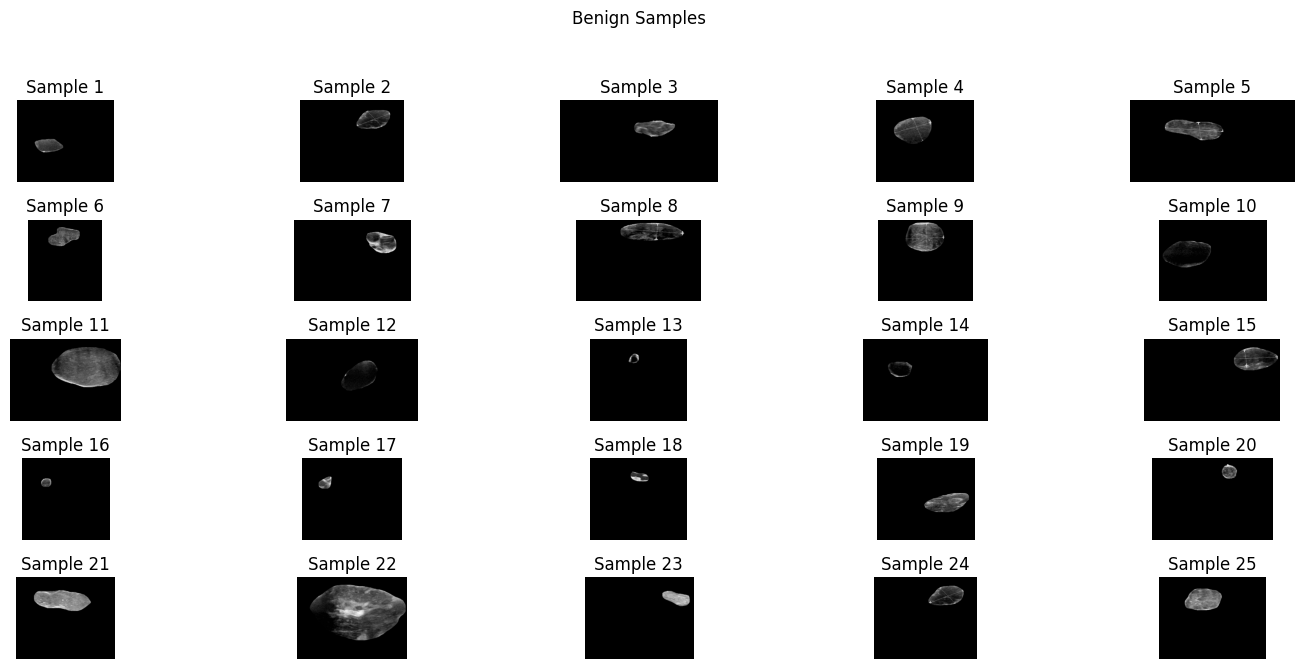

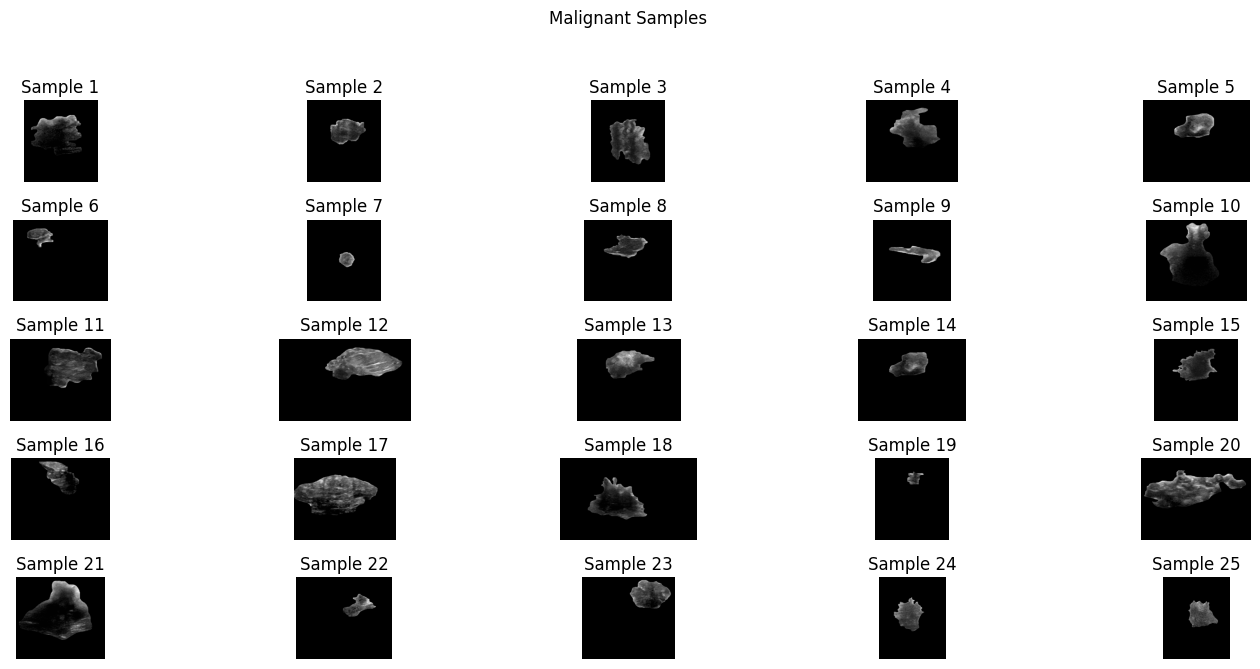

In [33]:
def plot_class_samples(base_path, class_name, num_samples=10):
    plt.figure(figsize=(15, 7))
    class_folder = os.path.join(base_path, class_name)
    image_files = [os.path.join(class_folder, f) for f in os.listdir(class_folder) if f.endswith('.png')]

    for i in range(min(num_samples, len(image_files))):
        img_path = image_files[i]
        img = Image.open(img_path).convert('L')  # Load in grayscale
        ax = plt.subplot(5, 5, i + 1)  # Adjust subplot grid for 10 images: 2 rows and 5 columns
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Sample {i + 1}")
        ax.axis('off')

    plt.suptitle(f"{class_name.capitalize()} Samples")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

training_path = '/kaggle/input/breast-lesion-dataset2/Breast_lesion_dataset2/Training_data'

plot_class_samples(training_path, 'benign', num_samples=25)

plot_class_samples(training_path, 'malignant', num_samples=25)

In [34]:
def create_classification_df(base_path):
    categories = ['benign', 'malignant']
    data = []

    for category in categories:
        class_folder = os.path.join(base_path, category)
        # List files in the directory
        image_files = [f for f in os.listdir(class_folder) if f.endswith('.png')]

        # Create a list of dictionaries containing the filename and classification
        data.extend([{'filename': f, 'classification': category} for f in image_files])

    df = pd.DataFrame(data)
    return df

test_path = '/kaggle/input/breast-lesion-dataset2/Breast_lesion_dataset2/Test_data'
train_df = create_classification_df(training_path)
test_df = create_classification_df(test_path)

df = pd.concat([train_df, test_df])
print(train_df.shape)
print(test_df.shape)
print(df.head())

(799, 2)
(100, 2)
           filename classification
0    benign (2).png         benign
1  benign (285).png         benign
2       case041.png         benign
3  benign (300).png         benign
4  benign (428).png         benign


## Is there a class imbalance? 

In [36]:
print(train_df['classification'].value_counts())
print(test_df['classification'].value_counts())

classification
benign       541
malignant    258
Name: count, dtype: int64
classification
benign       50
malignant    50
Name: count, dtype: int64


# Model building

## Loading data with keras.preprocessing function (tip from Vlad)

In [37]:
training_path = '/kaggle/input/breast-lesion-dataset2/Breast_lesion_dataset2/Training_data'

# parameters for the dataset generation
batch_size = 32
img_height = 224  # what should the input size be? #224
img_width = 224   # ?

# Create training dataset from directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    labels='inferred',
    label_mode='int',   # Labels are returned as integers
    class_names=['benign', 'malignant'], # class names
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),  # resize images to the specified size
    shuffle=True,        # shuffles the data
    seed=123,            # seed for shuffling and transformations
    validation_split=0.2,  # image proportion for validation
    subset='training',
)

# Crreating validation set
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    labels='inferred',
    label_mode='int',
    class_names=['benign', 'malignant'],
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
)

Found 799 files belonging to 2 classes.
Using 640 files for training.
Found 799 files belonging to 2 classes.
Using 159 files for validation.


## Data preprocessing and augmentation 

## Edge detection: is it true that benign lesions are rather round and malignant ones are rather irregularly shaped? 

## Inspect Preprocessed Images?

## Baseline model

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from kerastuner import HyperModel

class EfficientNetHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        # Load EfficientNetB0 as the base model
        base_model = EfficientNetB0(include_top=False, input_shape=self.input_shape, weights='imagenet')
        base_model.trainable = False  # prevent changes to its learned weights

        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),  # better feature pooling
            layers.Dense(
                units=hp.Int('units', min_value=32, max_value=512, step=32),
                activation='relu'
            ),
            layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)),
            layers.Dense(1, activation='sigmoid')  # binary classification
        ])

        model.compile(
            optimizer=hp.Choice('optimizer', ['adam', 'sgd']),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

from kerastuner.tuners import RandomSearch

input_shape = (224, 224, 3)
hypermodel = EfficientNetHyperModel(input_shape)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,  # configurations to try
    executions_per_trial=1,  # times to train each configuration
    directory='my_tuner_dir',
    project_name='efficientnet_tuning'
)

In [ ]:
input_shape = (224, 224, 3)
hypermodel = EfficientNetHyperModel(input_shape)

In [ ]:
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,  # number of trials
    executions_per_trial=1,
    directory='my_dir',
    project_name='efficientNet_tuning'
)

tuner.search(dataset, validation_data=validation_dataset, epochs=10)

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]

print('Best model summary:')
best_model.summary()
print('Best hyperparameters:', best_hyperparameters.values)

### Best model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0

def build_efficientnet_model():
    base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # global average pooling layer
        Dense(416, activation='relu'),  # dense layer with 416 units
        Dropout(0.2),  # dropout with rate 0.2
        Dense(1, activation='sigmoid')  # for binary classification
    ])

    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

model = build_efficientnet_model()

model.summary()

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Setup callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Train the model
history = model.fit(
    dataset,  # Your pre-batched training dataset
    epochs=20,  # Number of epochs to train for
    validation_data=validation_dataset,  # Your pre-batched validation dataset
    callbacks=callbacks  # Include callbacks for early stopping and saving the best model
)

In [39]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

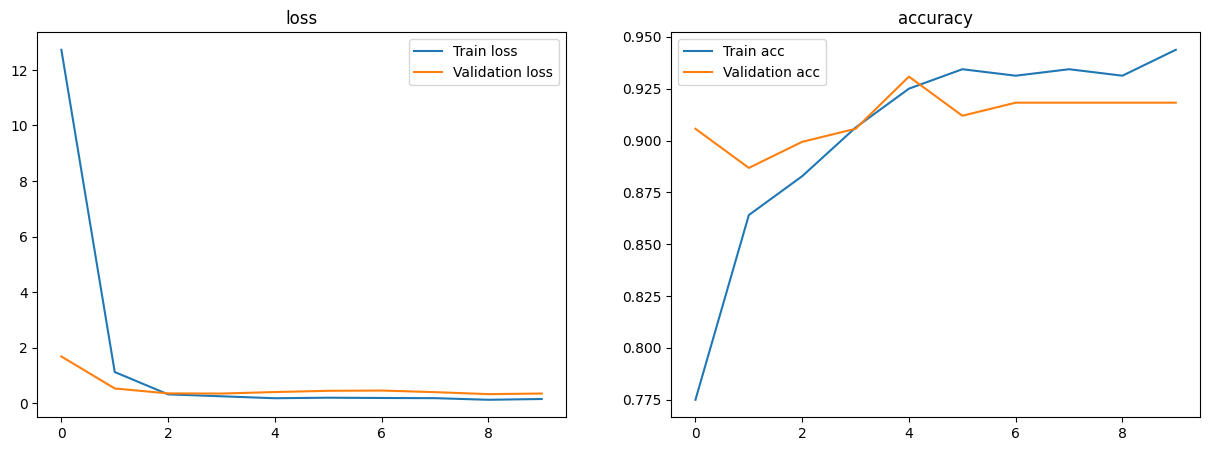

In [44]:
plot_history(history)
#plt.savefig('my_image.png')
#plt.show();

In [45]:
# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_path,
    shuffle=True,
    image_size=(224, 224),
    color_mode='rgb',
    batch_size=32)

# evaluate model on test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 100 files belonging to 2 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.8200 - loss: 1.6036
Test Loss: 2.813150644302368
Test Accuracy: 0.800000011920929
